In [1]:
%config InlineBackend.figure_formats = ['png2x']  # for vector graphics quality, set to svg
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3                # show some output
sc.logging.print_version_and_date()

Running Scanpy 1.3.7 on 2019-03-21 11:49.


In [2]:
# help(sc.read)

In [3]:
def prepare_rpkmforgenes_for_scanpy(infile, outfile):
    of = open(outfile,'w')
    h = True
    for line in open(infile):
        parts = line.strip().split("\t")
        if h:
            samples = len(parts)-1
            h=False
            of.write(line)
            continue
        else:
            of.write("%s\t%s\n" % (parts[0], "\t".join(parts[2:2+samples])))
    of.close()
    
    
prepare_rpkmforgenes_for_scanpy('refseq_rpkms.txt',
                                'refseq_rpkms_scanpy.txt')


In [3]:
# read data from any path on your system                                                                                                                                         
adata = sc.read('refseq_rpkms_scanpy.txt')

# other data reading examples
# adata = sc.read(path_to_data + 'myexample.csv')
# adata = sc.read(path_to_data + 'myexample.h5', sheet='countmatrix')
# adata = sc.read(path_to_data + 'myexample.xlsx', sheet='countmatrix')
# adata = sc.read(path_to_data + 'myexample.txt')

# in the data matrix adata.X, rows should correspond to samples and columns to genes                                                                                                             
# to match this convention, transpose your data if necessary                                                                                                                     
adata = adata.transpose()

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
# prepare meta data from names
cellnames = adata.obs_names
print(cellnames[:3])

Index(['EpRas_2h_11', 'EpRas_2h_14', 'EpRas_2h_13'], dtype='object')


In [5]:
cellline = ['NA' for i in range(721)]
cellstate = ['NA' for i in range(721)]
celllinestate = ['NA' for i in range(721)]
cellinvivo = ['NA' for i in range(721)]

In [6]:
for cidx, cellname in enumerate(cellnames):
    blocks = cellname.split("_")
    if  blocks[1] == 'TGFB':
        blocks[0] = 'EpRas+TGFB'
        blocks[1] = blocks[2]
        
    if blocks[0] in ('EpRas','EpXT','EpRas+TGFB'):
        cellline[cidx] = blocks[0]
    else:
        print(cidx, cellname, blocks, cellline[cidx])
        
    if blocks[1] in ('2h','8d','in'):
        if blocks[1] == 'in':
            cellstate[cidx] = 'invitro'
            cellinvivo[cidx] = 0
        else:
            cellstate[cidx]=blocks[1]
            cellinvivo[cidx] = 1
    else:
        print('2nd', cidx, cellname, blocks)
    
    celllinestate[cidx] = '%s %s' % (cellline[cidx], cellstate[cidx])

In [7]:
print(set(cellline), set(cellstate), set(celllinestate))

{'EpRas+TGFB', 'EpXT', 'EpRas'} {'invitro', '8d', '2h'} {'EpRas+TGFB 8d', 'EpRas+TGFB 2h', 'EpXT 2h', 'EpXT invitro', 'EpXT 8d', 'EpRas+TGFB invitro', 'EpRas 2h', 'EpRas 8d', 'EpRas invitro'}


In [8]:
adata.obs['cellline'] = cellline
adata.obs['cellstate'] = cellstate
adata.obs['invivo'] = cellinvivo
adata.obs['celllinestate'] = celllinestate

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=1)
print(adata.X.shape)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 4387 genes that are detected in less than 1 cells
(721, 20195)


... storing 'cellline' as categorical
... storing 'cellstate' as categorical
... storing 'celllinestate' as categorical


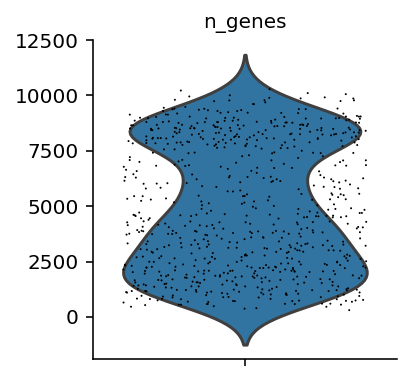

In [10]:
axs = sc.pl.violin(adata, ['n_genes'],
                   jitter=0.4, multi_panel=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


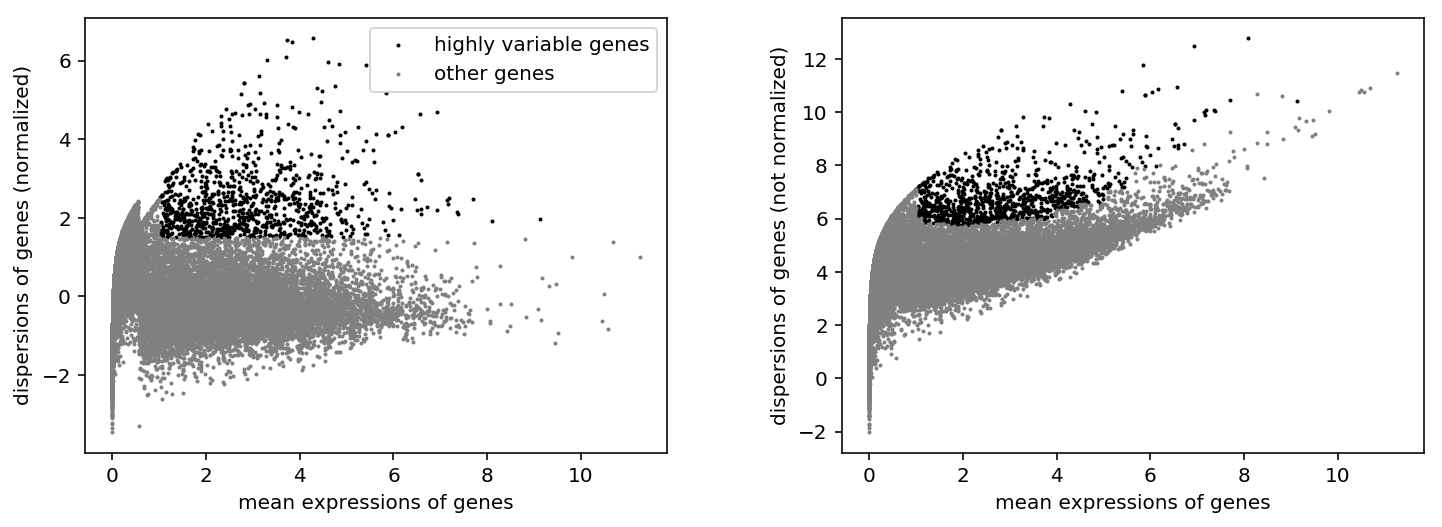

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=1.0125, max_mean=10, min_disp=1.5)
sc.pl.filter_genes_dispersion(filter_result)

In [12]:
adata_biolvar = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)
sc.pp.log1p(adata_biolvar)
print(adata.X.shape)
print(adata_biolvar.X.shape)

(721, 20195)
(721, 947)


In [13]:
sc.pp.neighbors(adata_biolvar)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
    finished (0:00:02.43) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [14]:
sc.tl.louvain(adata_biolvar)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.02) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


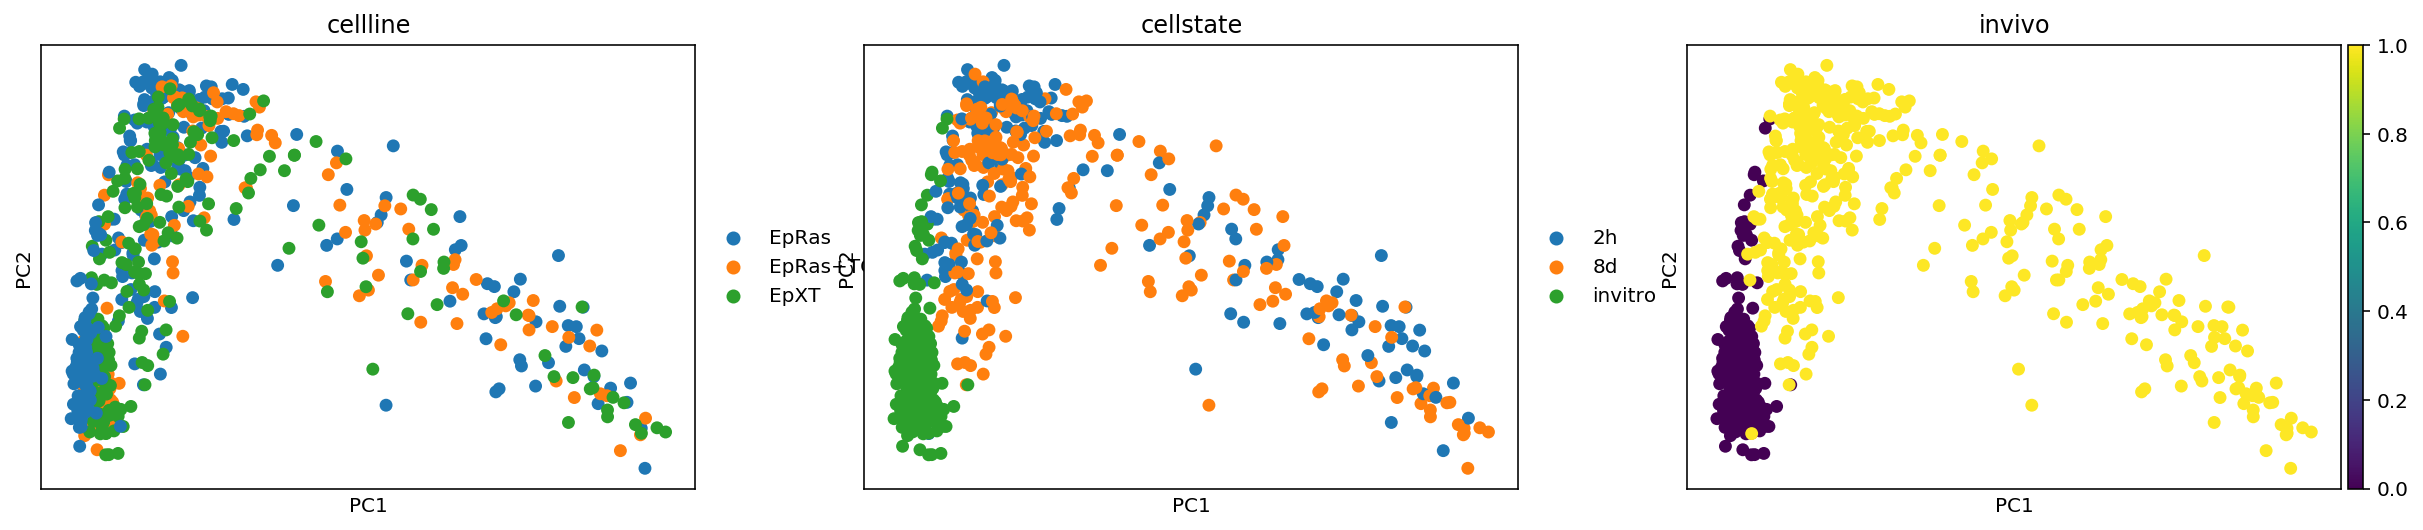

In [15]:
sc.tl.pca(adata_biolvar)
sc.pl.pca(adata_biolvar, color=['cellline','cellstate','invivo'])

computing UMAP
    finished (0:00:01.23) --> added
    'X_umap', UMAP coordinates (adata.obsm)


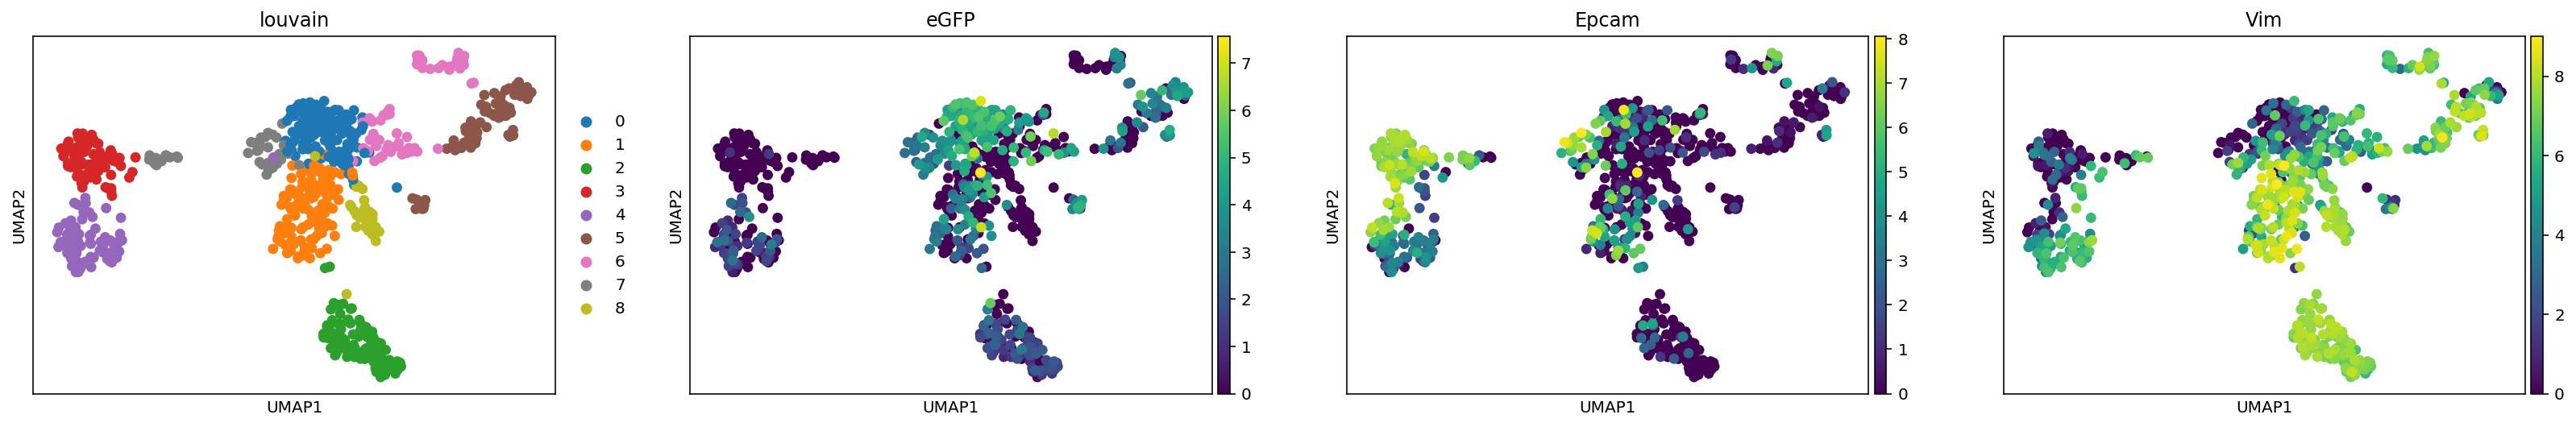

In [27]:
sc.tl.umap(adata_biolvar)
adata.obsm['X_umap'] = adata_biolvar.obsm['X_umap']
adata.obs['louvain'] = adata_biolvar.obs['louvain']
sc.pl.umap(adata,color=['louvain','eGFP', 'Epcam','Vim'])

ranking genes
    finished (0:00:00.02) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvainmarkers_for_louvain.pdf


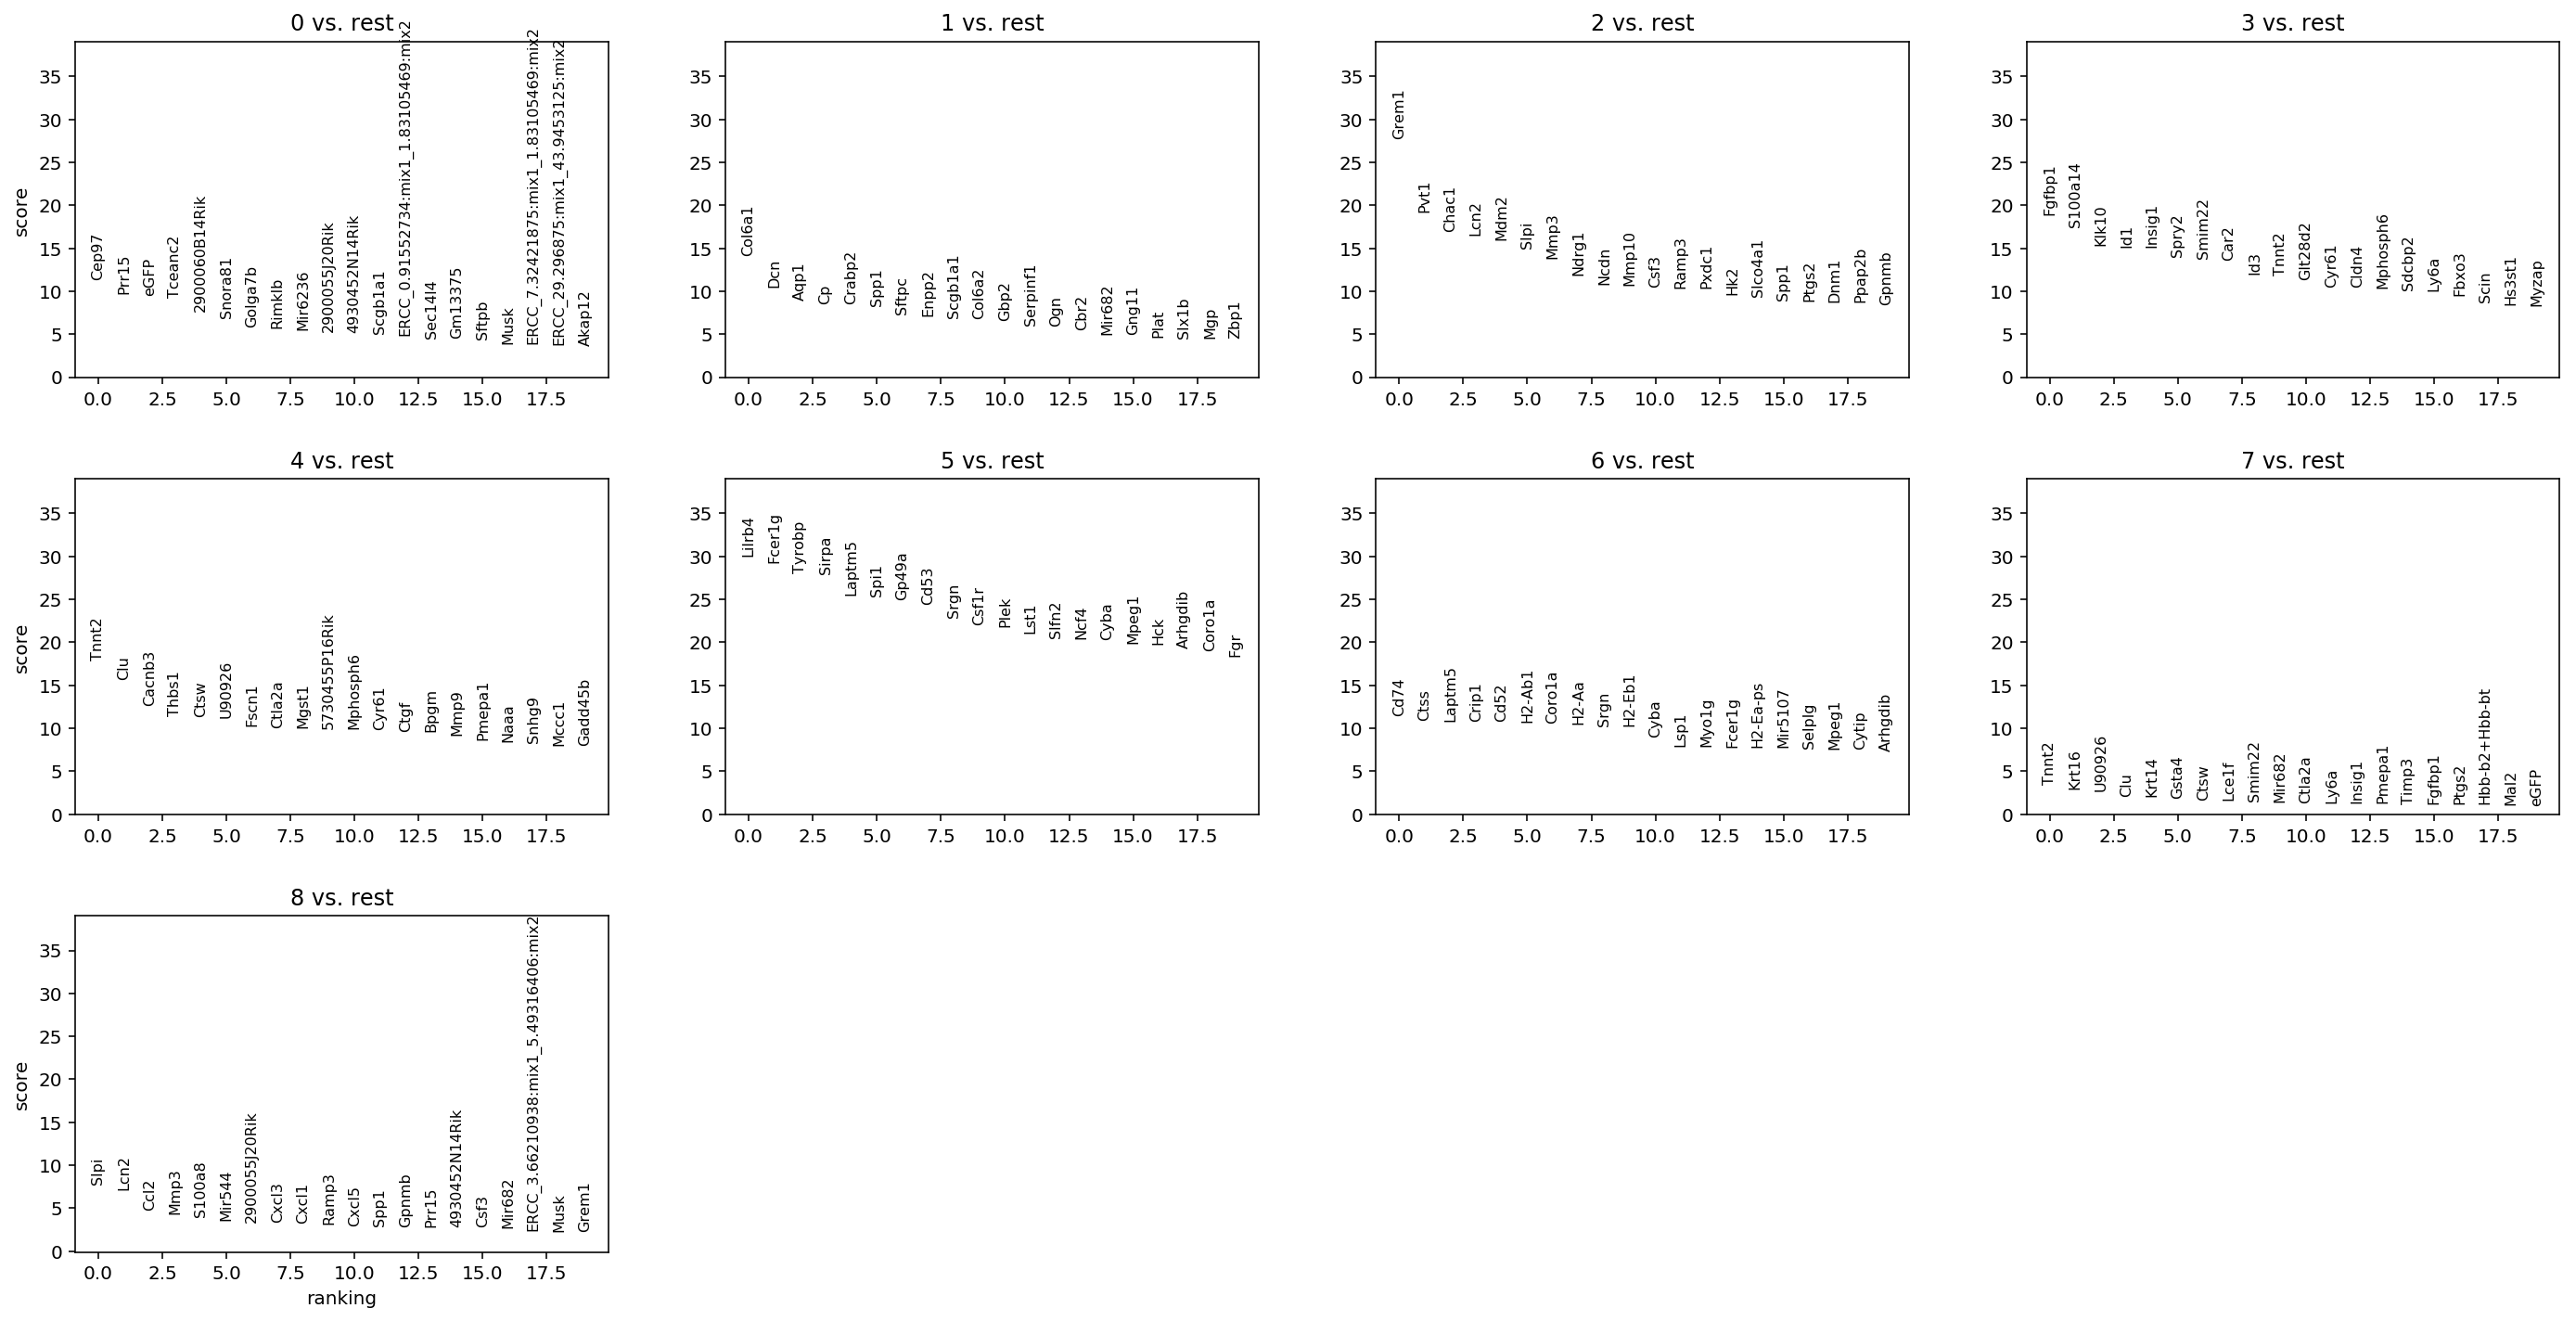

In [20]:
sc.tl.rank_genes_groups(adata_biolvar, 'louvain')
sc.pl.rank_genes_groups(adata_biolvar, n_genes=20, save='markers_for_louvain.pdf')

saving figure to file ./figures/dotplot_louvain_dotplot.pdf


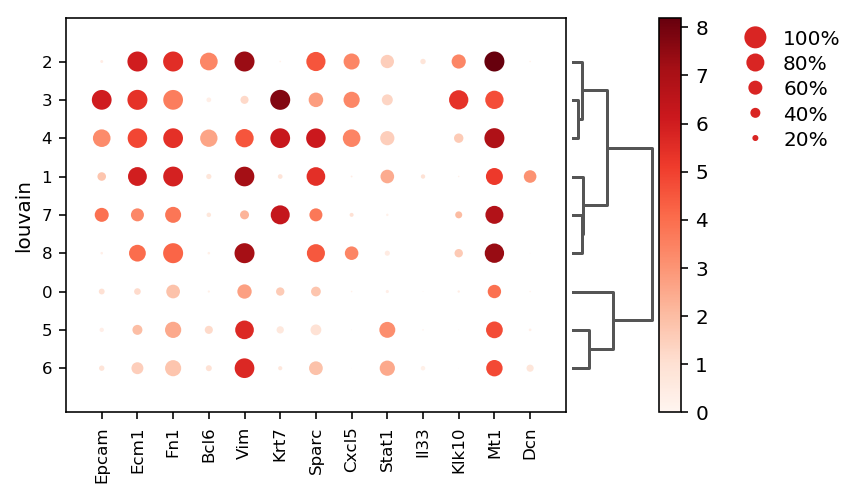

In [29]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain', dendrogram=True, save='_louvain_dotplot.pdf')

ranking genes
    finished (0:00:00.45) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/dotplot_louvain_rank_dotplot.pdf


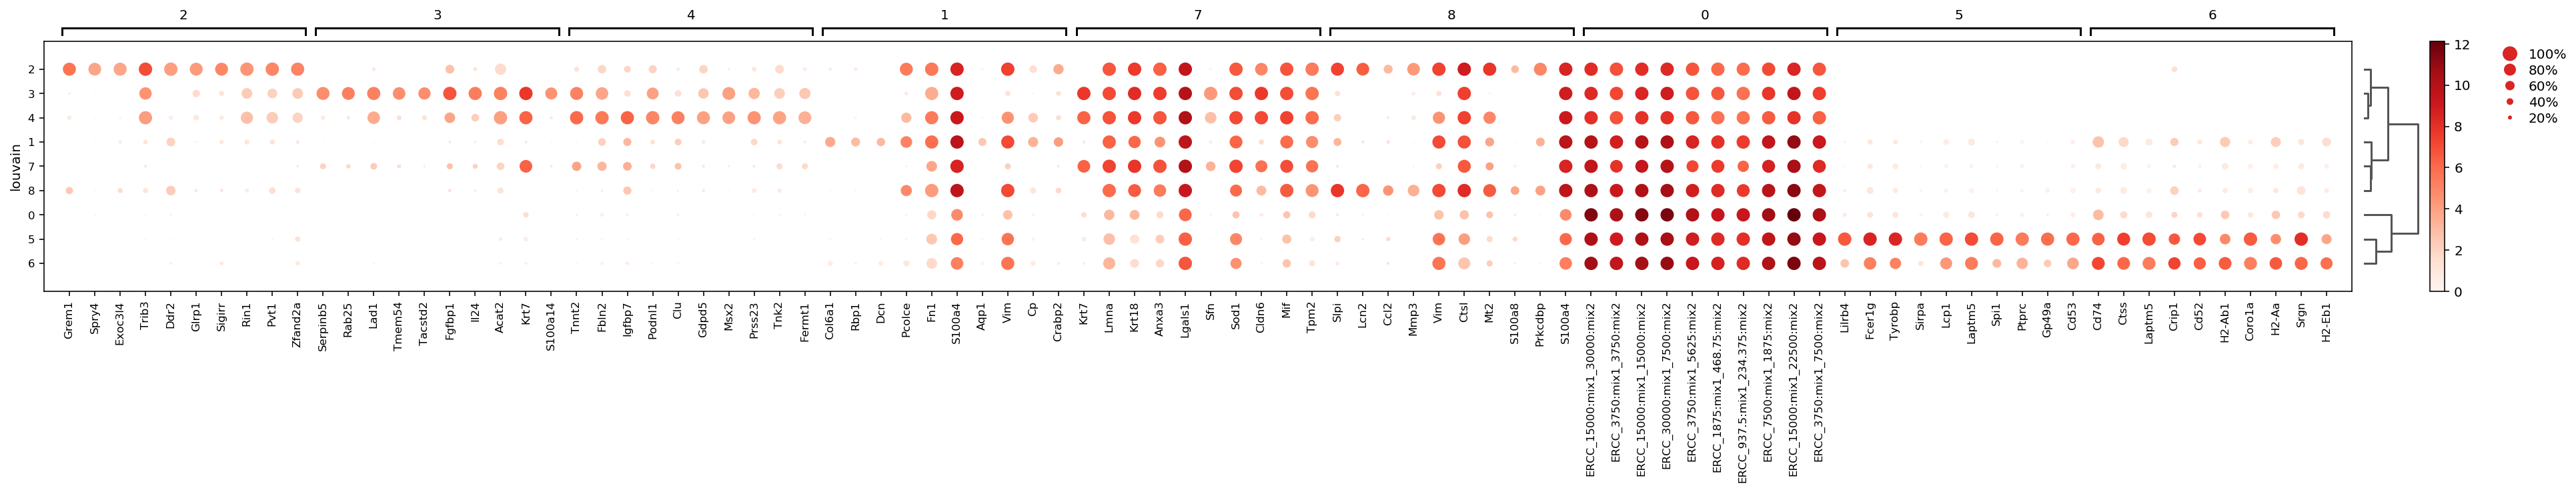

In [32]:
sc.tl.rank_genes_groups(adata, 'louvain')
ax = sc.pl.rank_genes_groups_dotplot(adata, groupby='louvain', dendrogram=True, save='_louvain_rank_dotplot.pdf')

saving figure to file ./figures/stacked_violinEMTmarkers-bylouvain.pdf


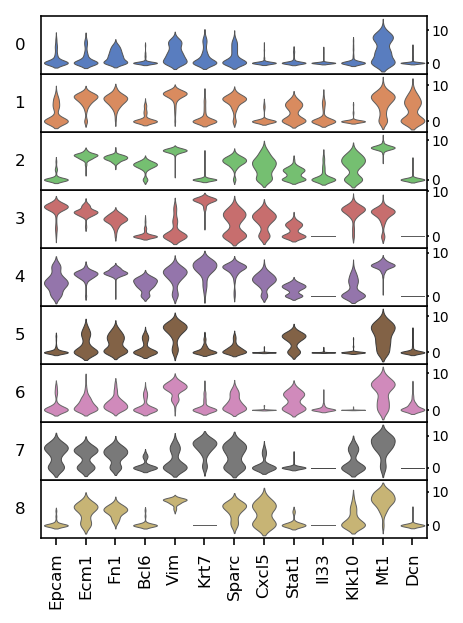

In [28]:
marker_genes = ['Epcam','Ecm1','Fn1','Bcl6','Vim','Krt7','Sparc','Cxcl5','Stat1','Il33','Klk10','Mt1','Dcn']
ax = sc.pl.stacked_violin(
    adata, marker_genes, groupby='louvain', save='EMTmarkers-bylouvain.pdf')

In [18]:
sc.tl.tsne(adata_biolvar, n_pcs=10)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:01.05) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [20]:
adata.obsm['X_tsne'] = adata_biolvar.obsm['X_tsne']

saving figure to file ./figures/tsne.pdf


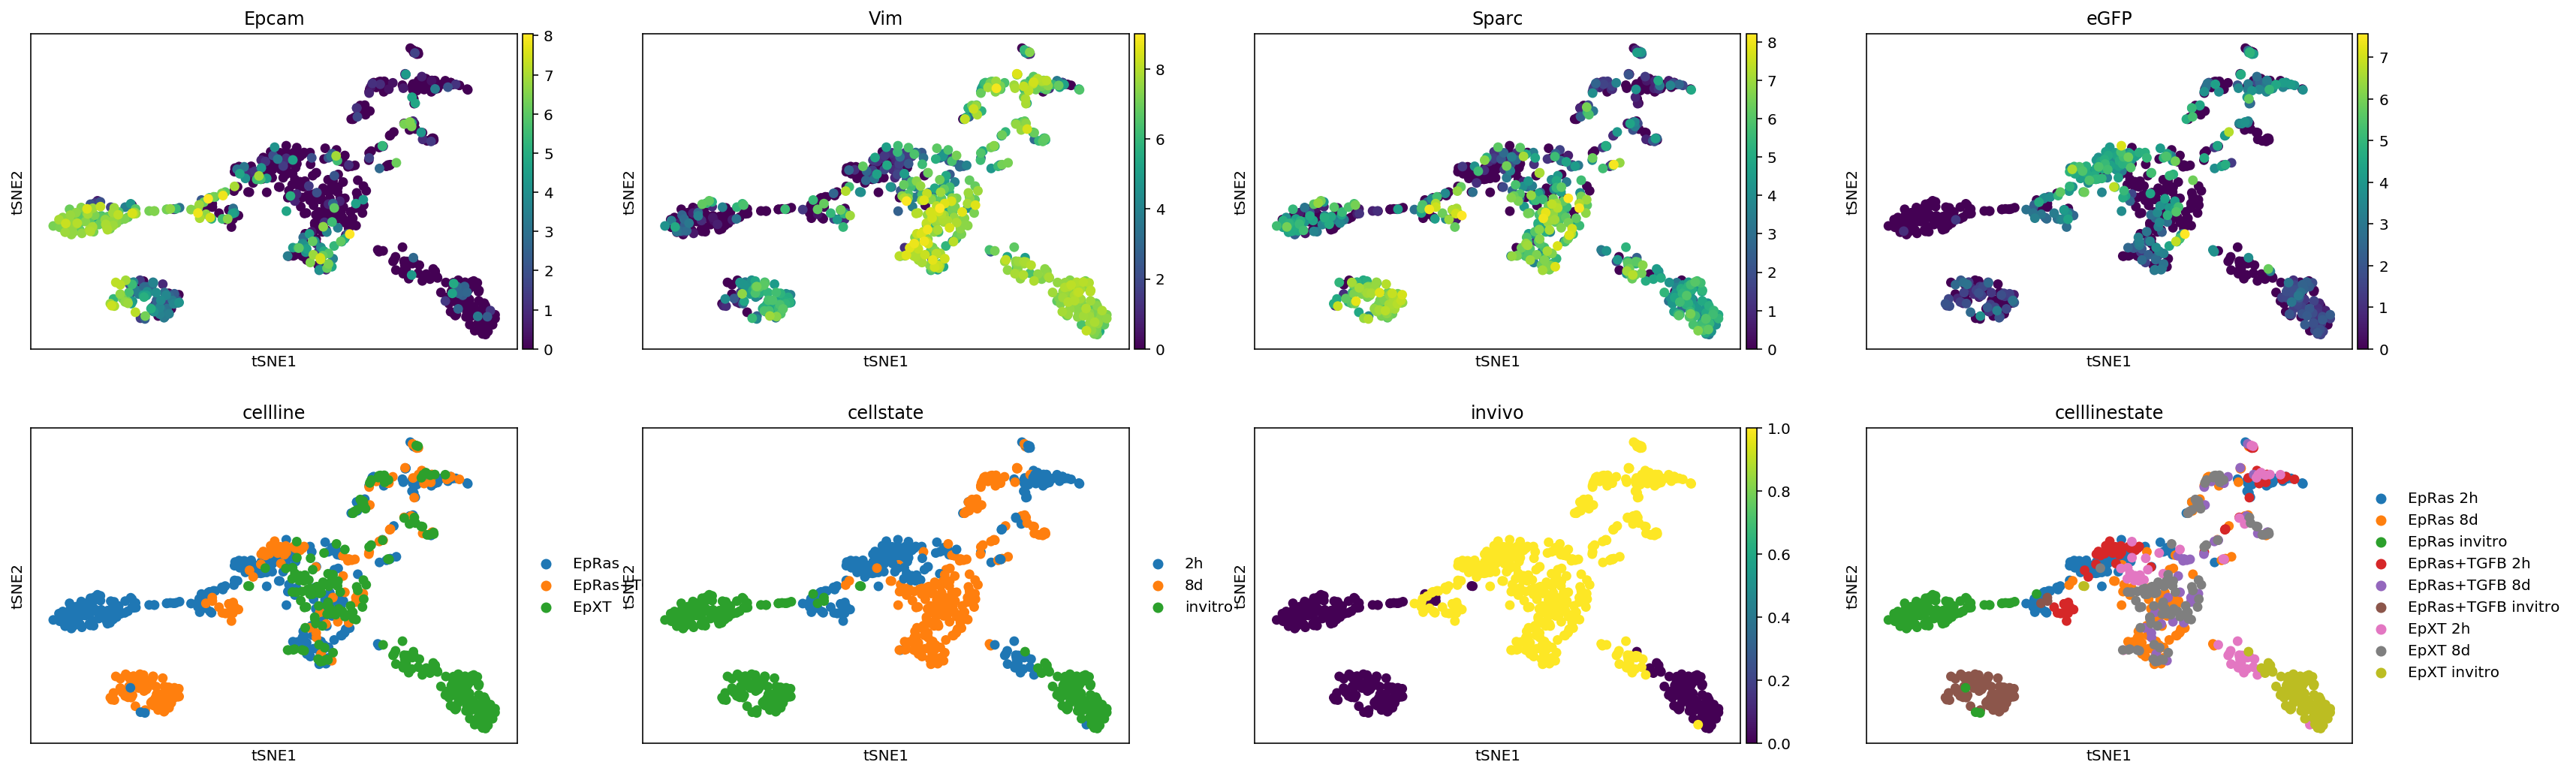

In [21]:
ax = sc.pl.tsne(adata, color=['Epcam','Vim','Sparc','eGFP','cellline','cellstate','invivo','celllinestate'], save='.pdf')

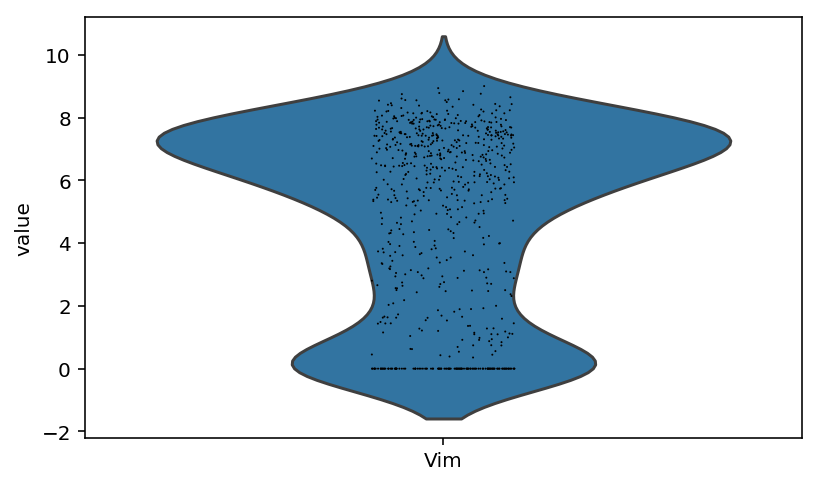

In [22]:
ax = sc.pl.violin(adata, 'Vim', group_by='celllinestate')

In [23]:
sc.tl.umap(adata_biolvar)

computing UMAP
    finished (0:00:01.97) --> added
    'X_umap', UMAP coordinates (adata.obsm)


saving figure to file ./figures/umap.pdf


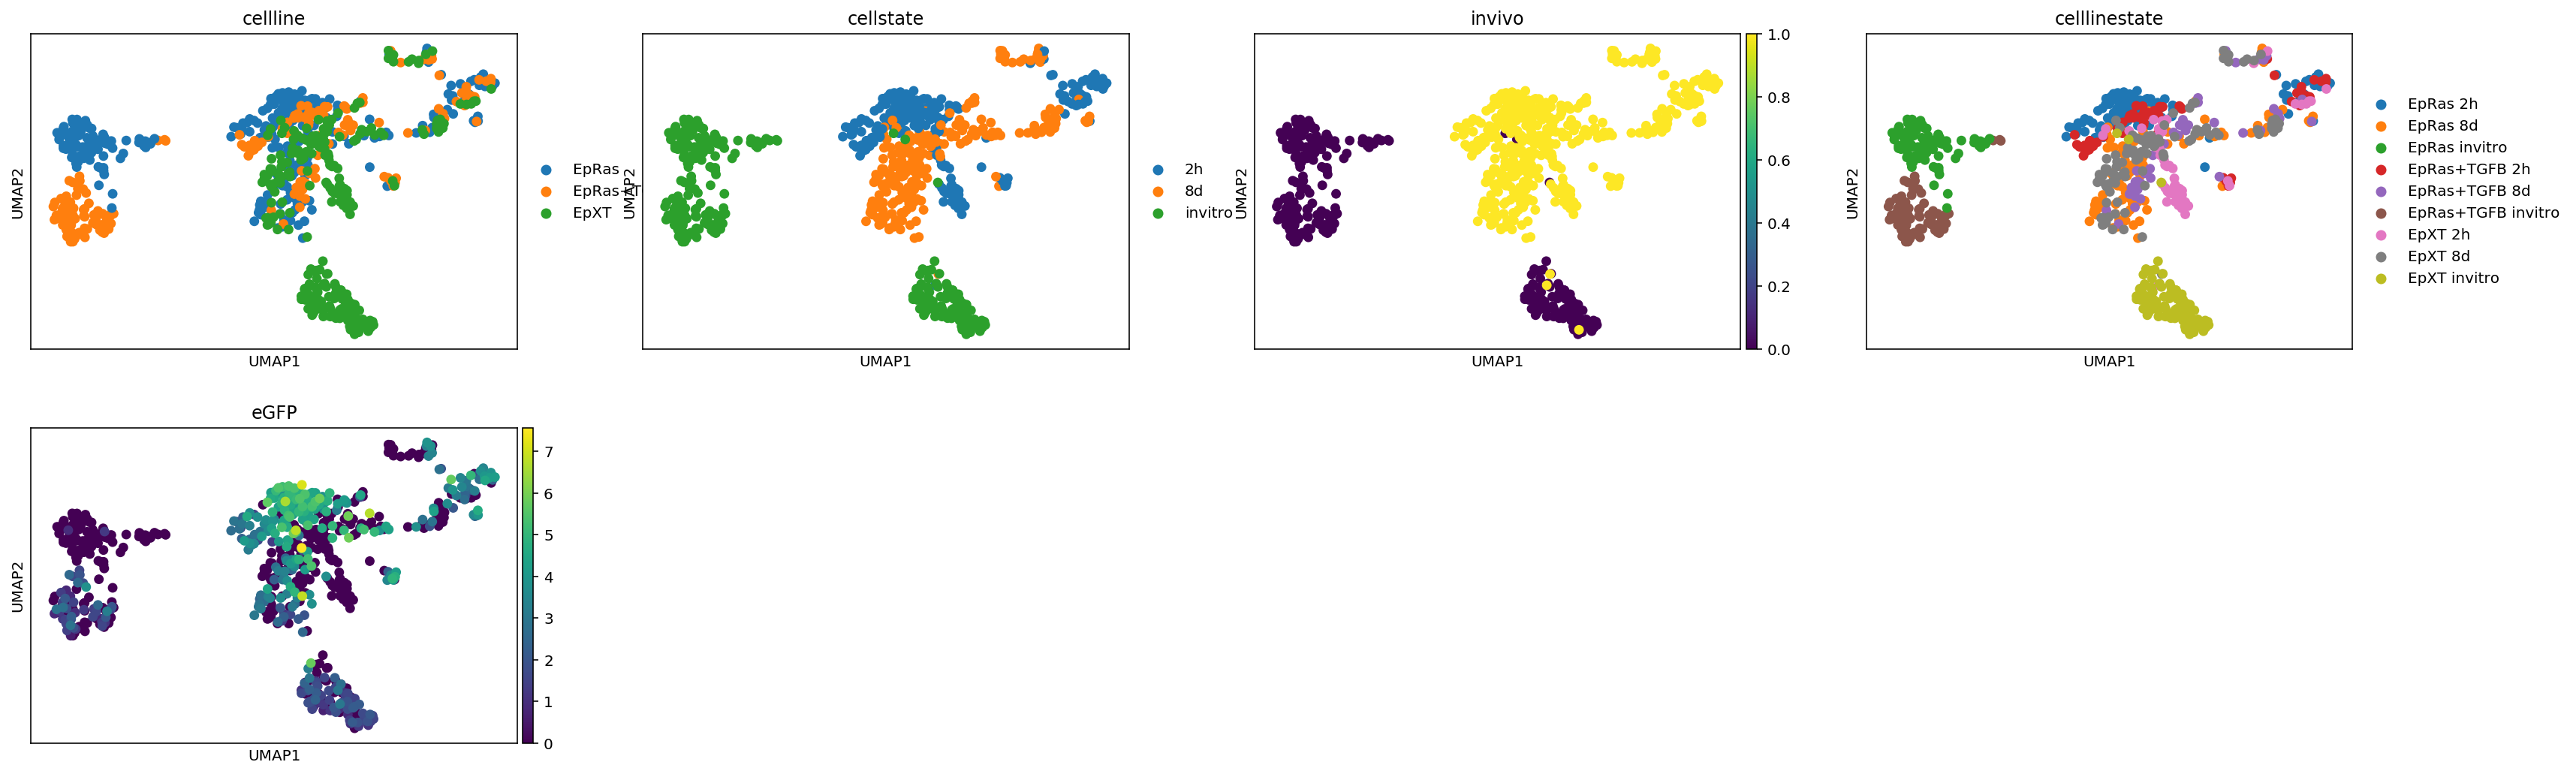

In [31]:
sc.pl.umap(adata_biolvar, color=['cellline','cellstate','invivo','celllinestate','eGFP'], save='.pdf')

# Plot markers across cell lines and samplings stages

In [32]:
marker_genes = ['Epcam','Ecm1','Fn1','Bcl6','Vim','Krt7','Sparc','Cxcl5','Stat1','Il33','Klk10','Mt1','Dcn']

saving figure to file ./figures/stacked_violinstack1.pdf


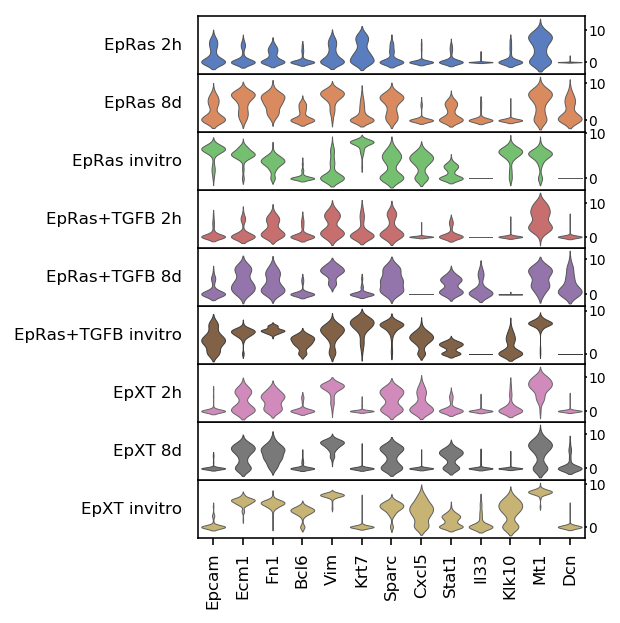

In [33]:
ax = sc.pl.stacked_violin(
    adata, marker_genes, groupby='celllinestate', save='stack1.pdf')

saving figure to file ./figures/stacked_violinstack2.pdf


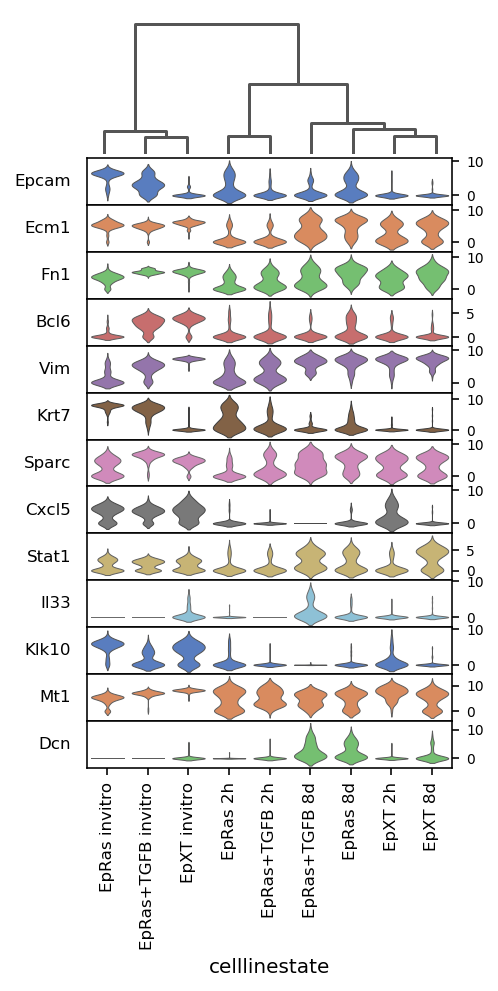

saving figure to file ./figures/stacked_violinstack3.pdf


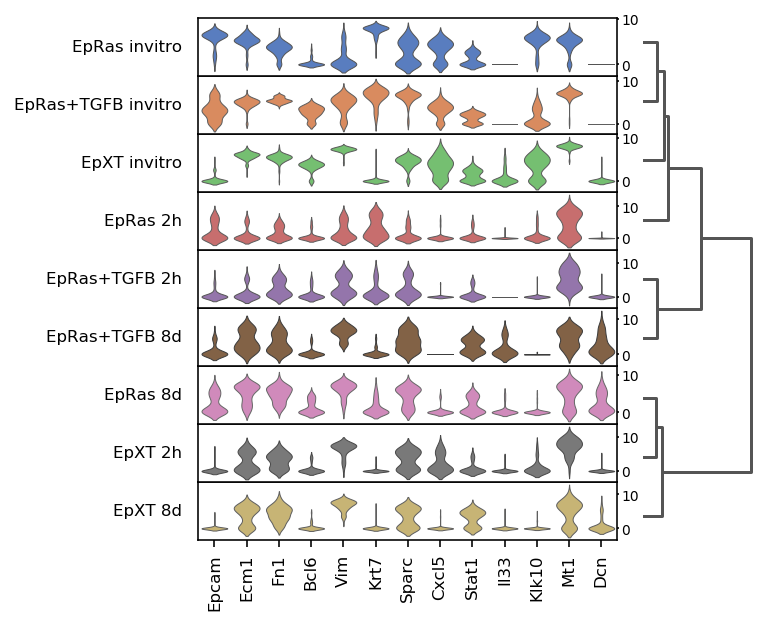

In [33]:
ax = sc.pl.stacked_violin(
    adata, marker_genes, groupby='celllinestate', swap_axes=True, 
    dendrogram=True, save='stack2.pdf')
ax = sc.pl.stacked_violin(
    adata, marker_genes, groupby='celllinestate',
    dendrogram=True, save='stack3.pdf')

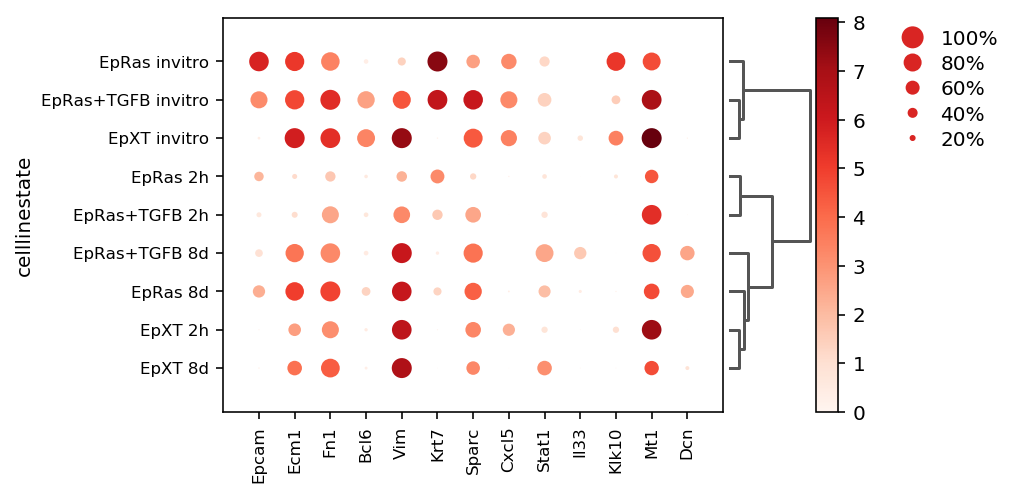

In [35]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='celllinestate', dendrogram=True)

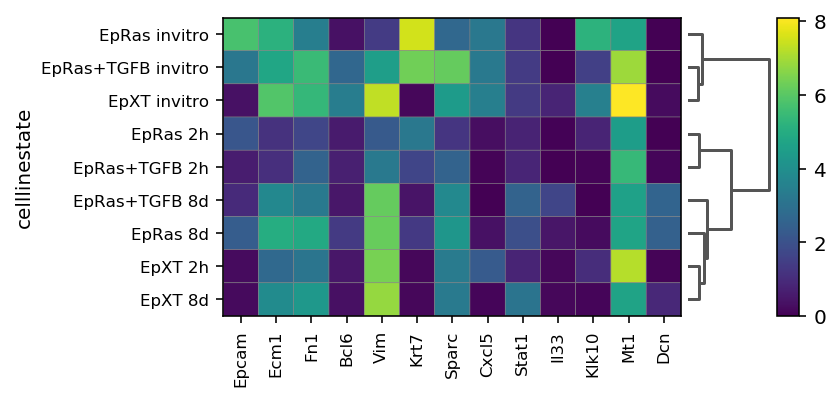

In [36]:
ax = sc.pl.matrixplot(adata, marker_genes, groupby='celllinestate', dendrogram=True)

ranking genes


/home/rickards/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/rickards/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:00:04.19) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids

saving figure to file ./figures/stacked_violin.pdf


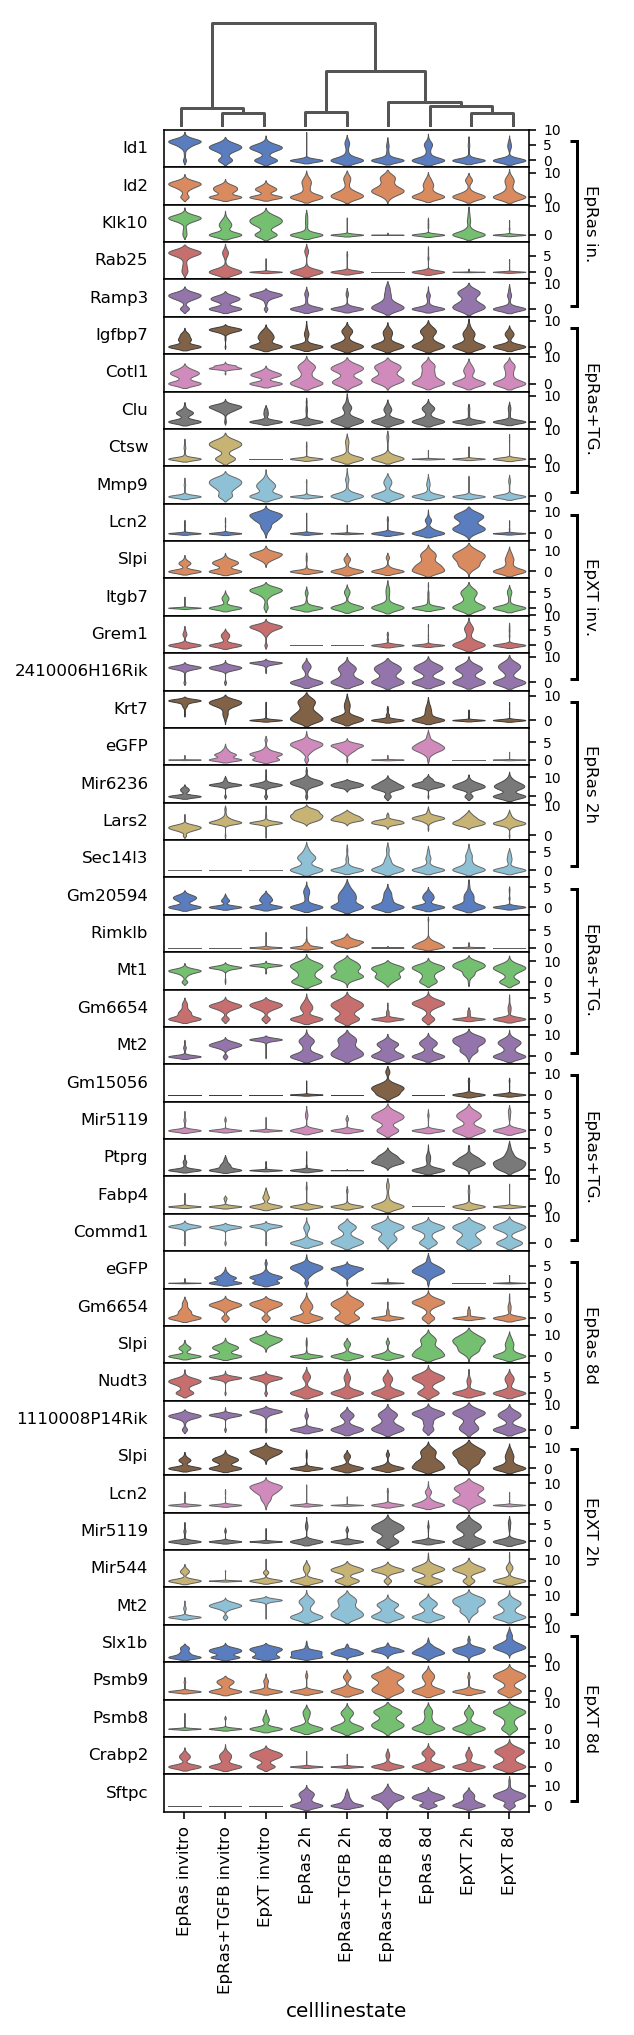

In [37]:
sc.tl.rank_genes_groups(adata, groupby='celllinestate', method='logreg')
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5,swap_axes=True, save='.pdf')

In [38]:
adata.write('emt.h5ad')

In [39]:
sc.tl.diffmap(adata_biolvar)

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9913438  0.9883745  0.9763731  0.96759135 0.96213037
     0.9539621  0.9229332  0.9182895  0.9122491  0.9095185  0.90220785
     0.888834   0.8782011  0.8583936 ]
    finished (0:00:00.02) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


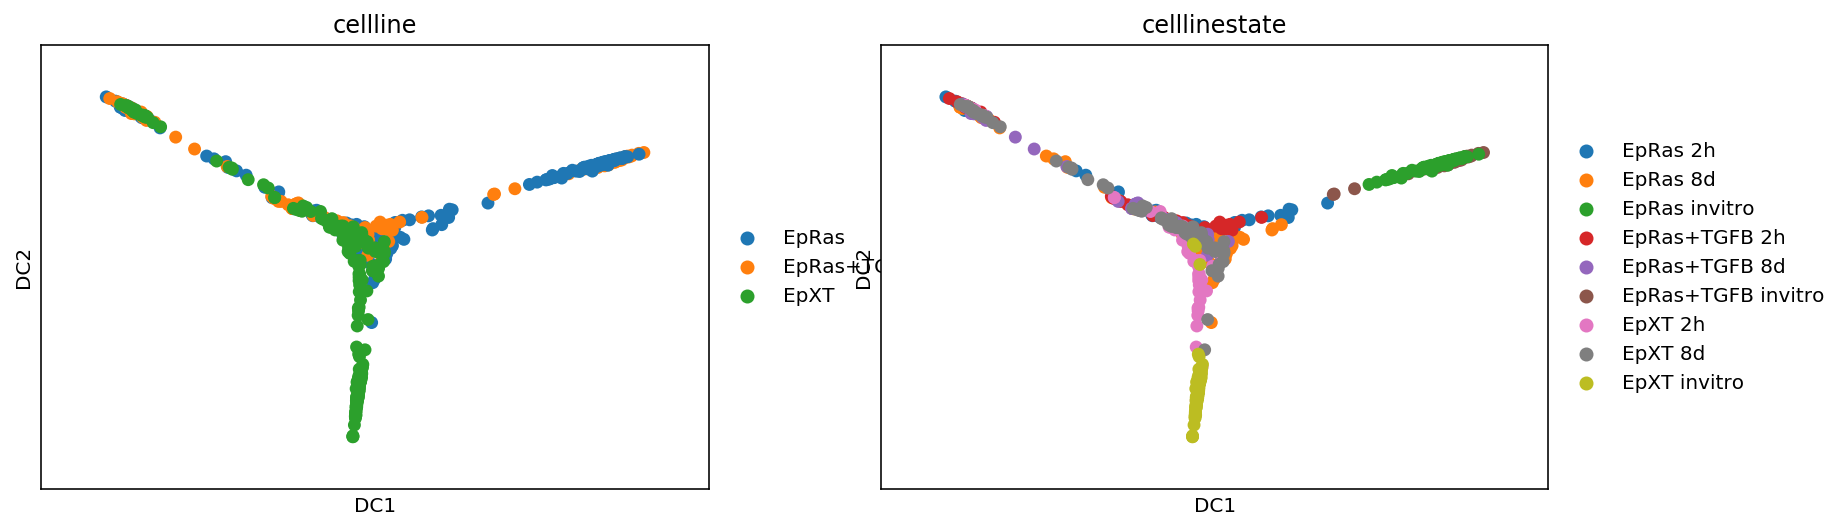

In [40]:
sc.pl.diffmap(adata_biolvar, color=['cellline','celllinestate'])

saving figure to file ./figures/violin.pdf


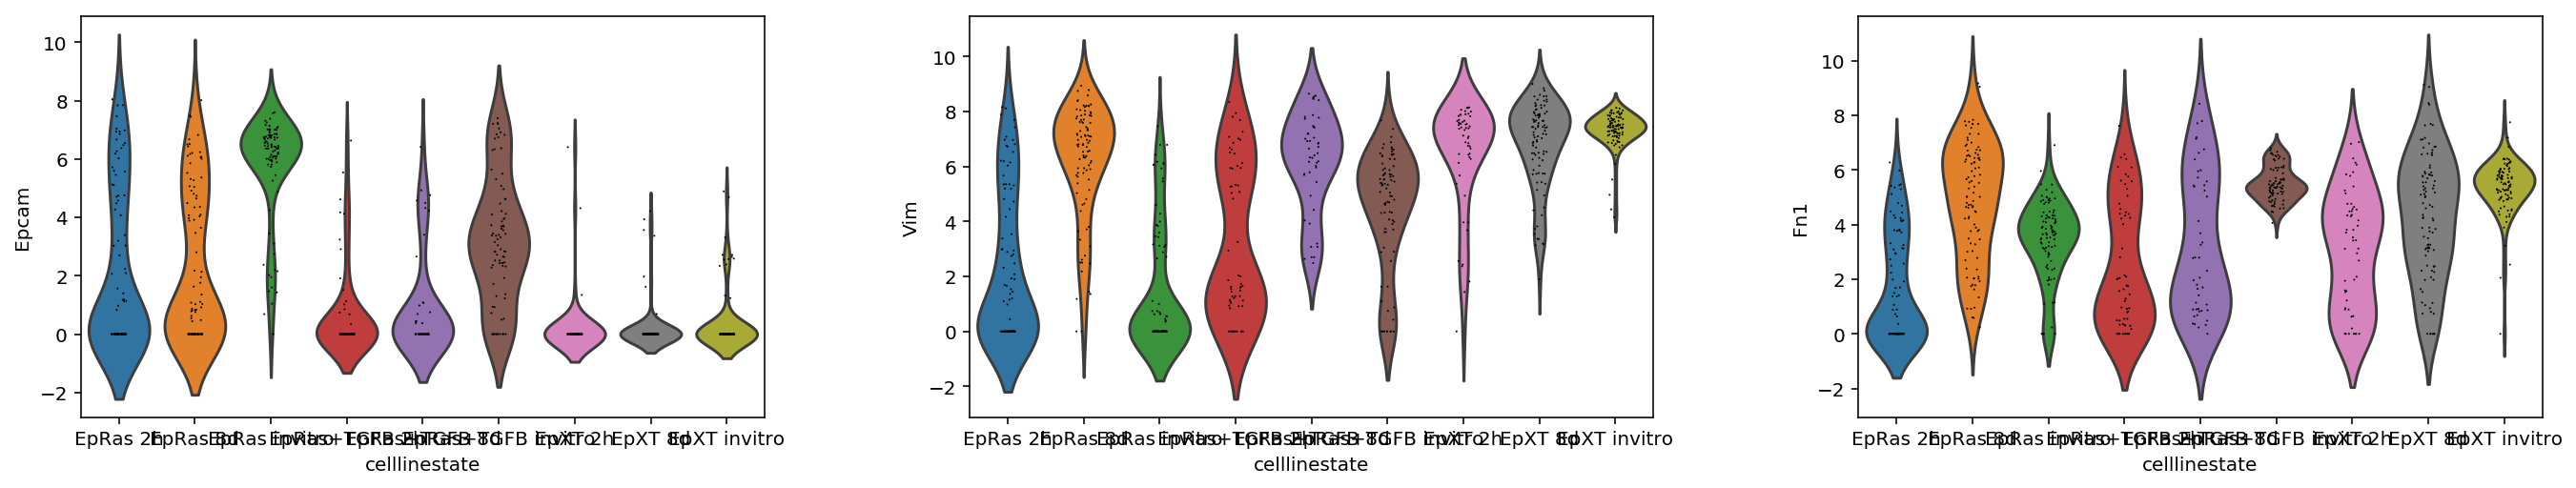

In [41]:
sc.pl.violin(adata, ['Epcam', 'Vim', 'Fn1'], groupby='celllinestate', save='.pdf')

In [42]:
sc.tl.score_genes(adata, gene_list=['Vim','Fn1','Sparc','Dcn','Aqp1'])

computing score 'score'


ValueError: Length of passed values is 20273, index implies 20195

## Test differential expressions

In [43]:
import diffxpy.api as de

In [56]:
test = de.test.wilcoxon(
    data=adata,
    grouping="condition",
    sample_description=sample_desc
)


/home/rickards/anaconda3/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [54]:
import pandas as pd
sample_desc = pd.DataFrame({"observations":range(721),"condition":cellinvivo})

In [55]:
sample_desc.head()

observations  condition
0             0          1
1             1          1
2             2          1
3             3          1
4             4          1

In [57]:
test.qval

array([3.2025384615e-05, 7.4691267686e-01, 2.7014397515e-44, ...,
       2.3518054146e-02, 3.2602573083e-01, 2.8659413081e-15])

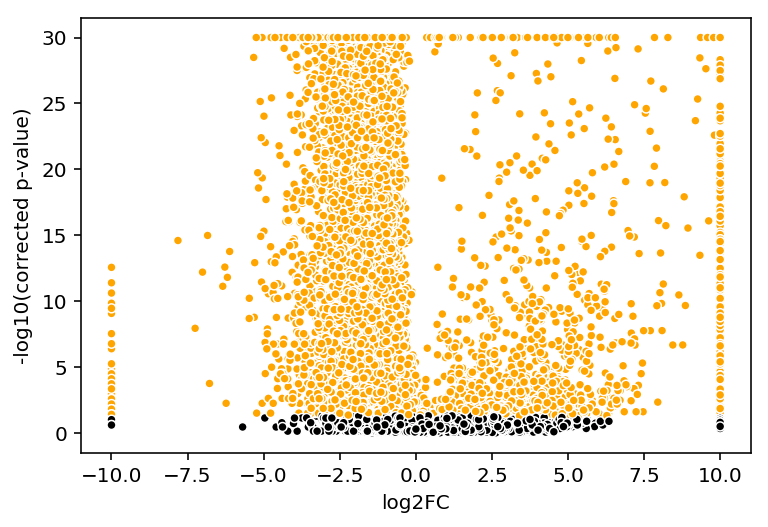

In [58]:
test.plot_volcano()

In [98]:
# compare EpRas 2h vs 8h
adata_EpRas2h = adata[adata.obs['celllinestate'] == 'EpRas 2h'].obs_names
adata_EpRas8d = adata[adata.obs['celllinestate'] == 'EpRas 8d'].obs_names
comb = adata_EpRas2h.tolist() + adata_EpRas8d.tolist()
adata_2v8 = adata[comb]
adata_2v8

View of AnnData object with n_obs × n_vars = 191 × 20195 
    obs: 'cellline', 'cellstate', 'invivo', 'celllinestate', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'cellline_colors', 'cellstate_colors', 'celllinestate_colors', 'dendrogram', 'rank_genes_groups'
    obsm: 'X_tsne'

In [101]:
sample_desc_EpRas2v8 = pd.DataFrame({"observations":range(len(comb)),"condition":[1 if val == '2h' else 0 for val in adata_2v8.obs['cellstate']]})
sample_desc_EpRas2v8.head()
print(sum(sample_desc_EpRas2v8['condition']))

95


In [102]:
test_EpRas_2v8 = de.test.t_test(
    data=adata_2v8,
    grouping="condition",
    sample_description=sample_desc_EpRas2v8
)


/home/rickards/anaconda3/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [104]:
test_EpRas_2v8.qval

array([0.3928058371, 0.3928058371, 0.0320230906, ..., 0.9275284255,
       0.3928058371, 0.2322988024])

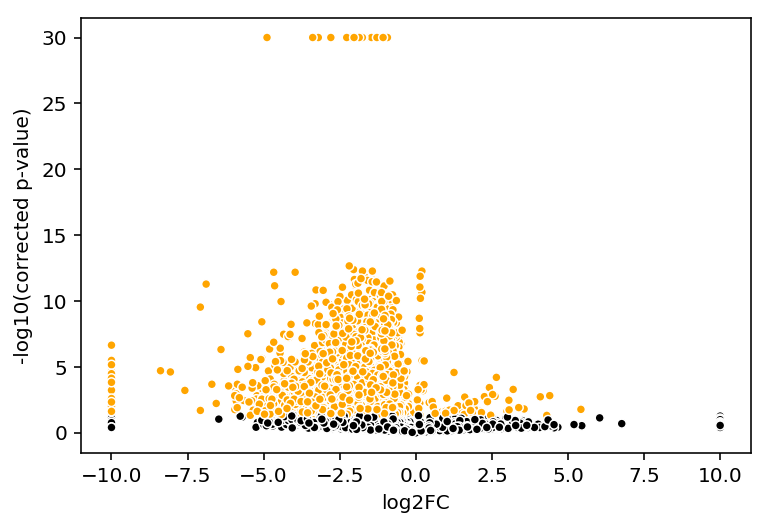

In [105]:
test_EpRas_2v8.plot_diagnostics()

In [108]:
test_EpRas_2v8.summary().iloc[:10,:]

gene      pval      qval    log2fc      mean  zero_mean  zero_variance
0  Adora1  0.317330  0.392806       inf  0.007762      False          False
1   Sntg1  0.317330  0.392806      -inf  0.005749      False          False
2   Prim2  0.011656  0.032023 -1.708874  0.425648      False          False
3    Bai3  0.648068  0.713859  0.979653  0.024684      False          False
4   Cflar  0.178174  0.296989 -0.383222  1.259640      False          False
5   Gpr39  0.001659  0.006268 -2.232076  0.442030      False          False
6   Obsl1  0.193001  0.315660      -inf  0.005963      False          False
7   Syt14  0.317331  0.392806       inf  0.013535      False          False
8    Pld5       NaN       NaN       NaN  0.000000       True           True
9   Lmx1a  0.317331  0.392806       inf  0.008686      False          False

In [115]:
df = test.summary()
df[df.gene=='Vim']

gene      pval      qval    log2fc      mean
1658  Vim  0.000472  0.000788  0.225276  4.852475

In [117]:
sc.pp.neighbors(adata_2v8)
sc.tl.umap(adata_2v8)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
    finished (0:00:00.14) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.34) --> added
    'X_umap', UMAP coordinates (adata.obsm)


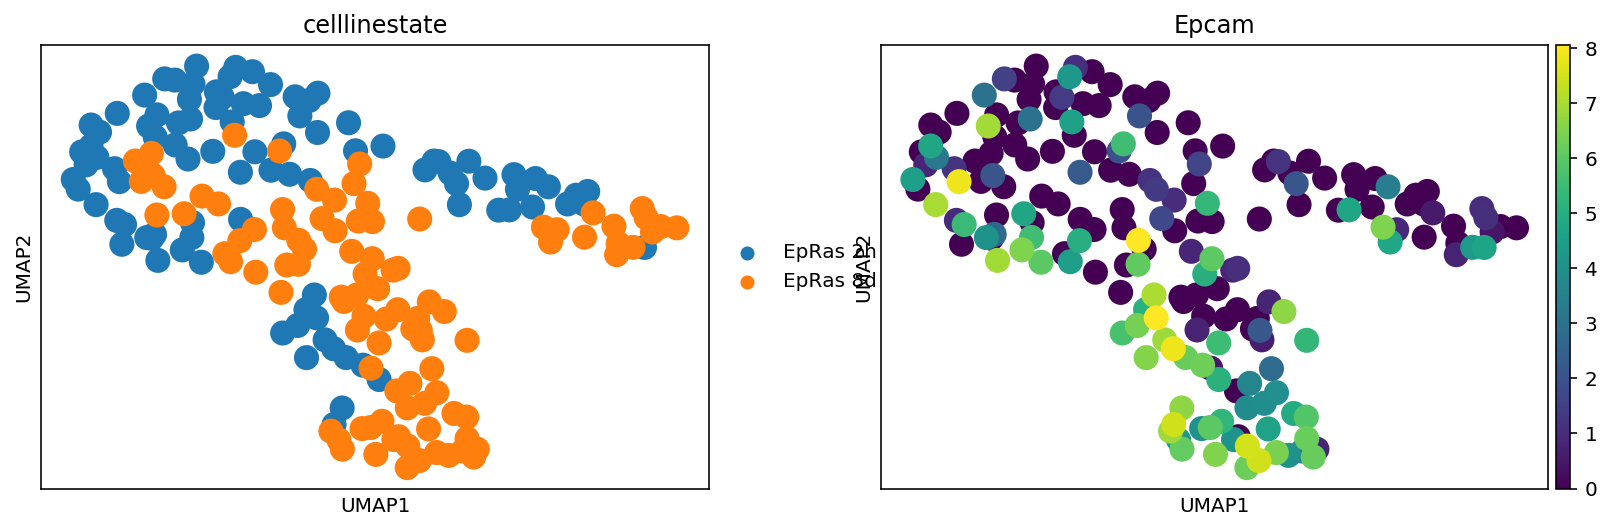

In [119]:
sc.pl.umap(adata_2v8, color=['celllinestate','Epcam'])

In [120]:
sc.tl.tsne(adata_2v8)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:00.24) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


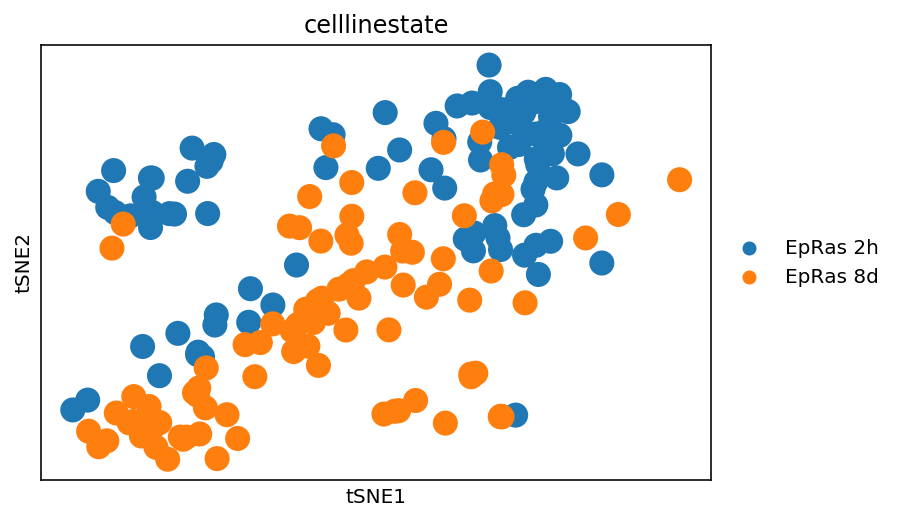

In [124]:
sc.pl.tsne(adata_2v8, color=['celllinestate'])

# ony in vitro cells

In [126]:
adata_invitro = adata[adata.obs['invivo']==0]

In [127]:
sc.pp.neighbors(adata_invitro)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
    finished (0:00:00.16) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [128]:
adata_invitro

AnnData object with n_obs × n_vars = 273 × 20195 
    obs: 'cellline', 'cellstate', 'invivo', 'celllinestate', 'n_genes', 'n_counts'
    var: 'n_cells'
    uns: 'cellline_colors', 'cellstate_colors', 'celllinestate_colors', 'dendrogram', 'rank_genes_groups', 'neighbors'
    obsm: 'X_tsne', 'X_pca'

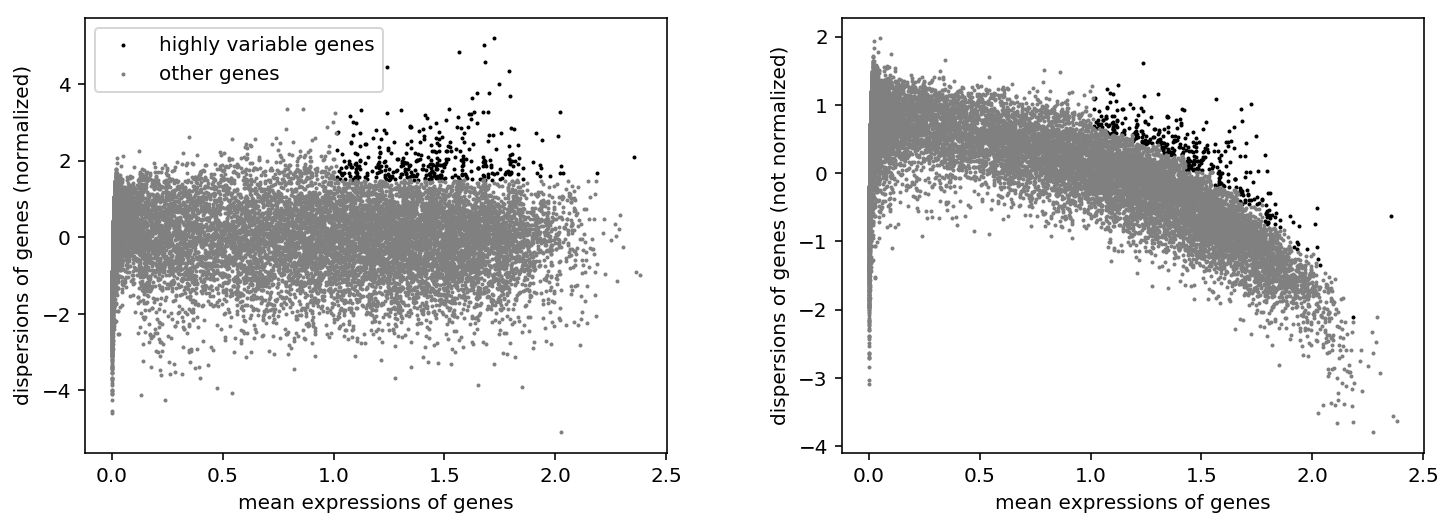

In [138]:
filter_result = sc.pp.filter_genes_dispersion(
    adata_invitro.X, min_mean=1.0125, max_mean=10, min_disp=1.5)
sc.pl.filter_genes_dispersion(filter_result)
adata_invitro_biolvar = adata_invitro[:, filter_result.gene_subset]


In [139]:
sc.tl.pca(adata_invitro_biolvar)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


saving figure to file ./figures/pcainvitro-pca.pdf


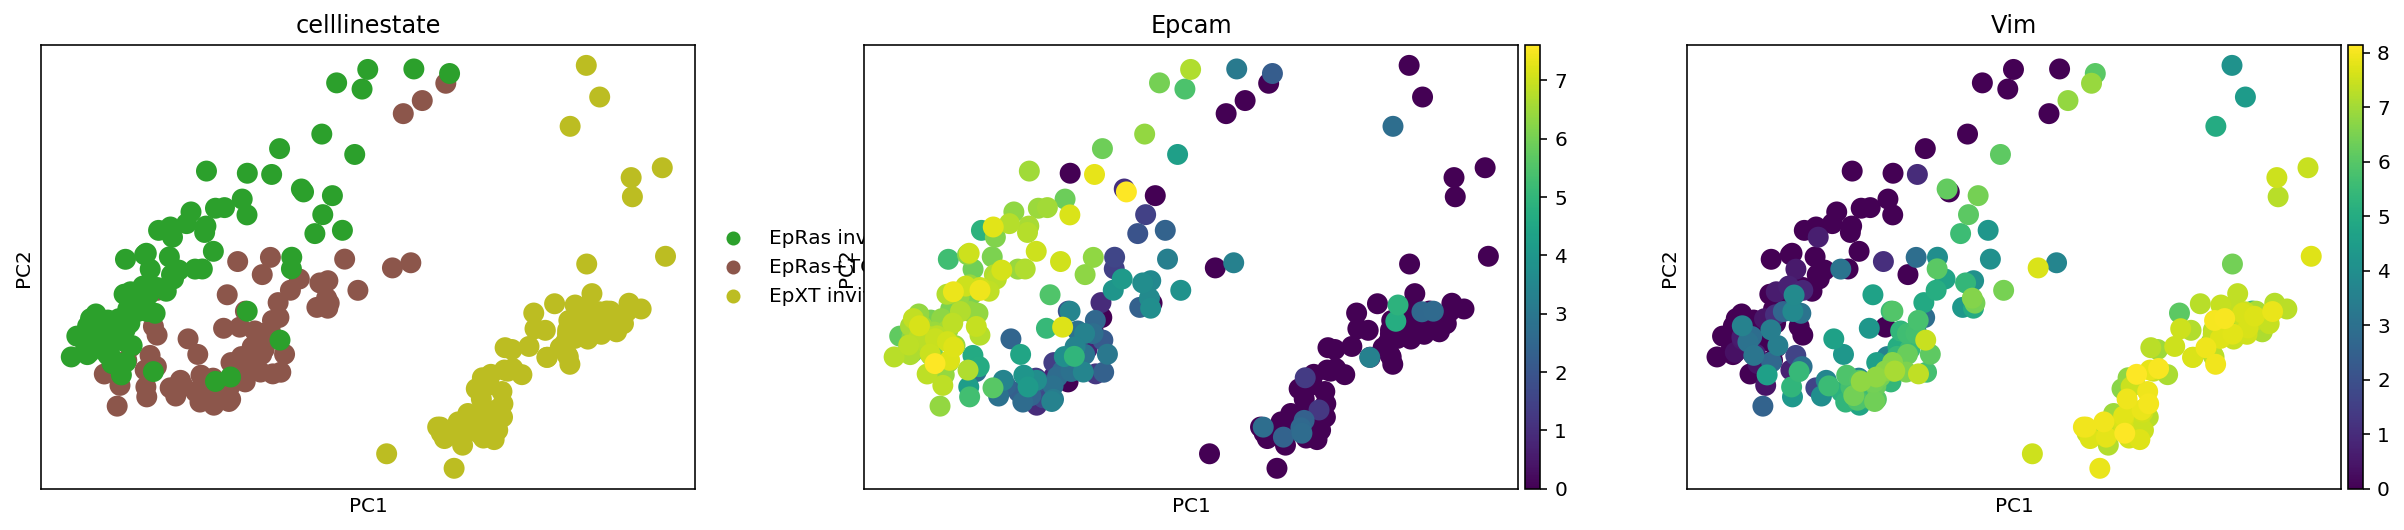

In [140]:
sc.pl.pca(adata_invitro_biolvar, color=['celllinestate', 'Epcam','Vim'], save='invitro-pca.pdf')

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:00.32) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
saving figure to file ./figures/tsneinvitro-tsne.pdf


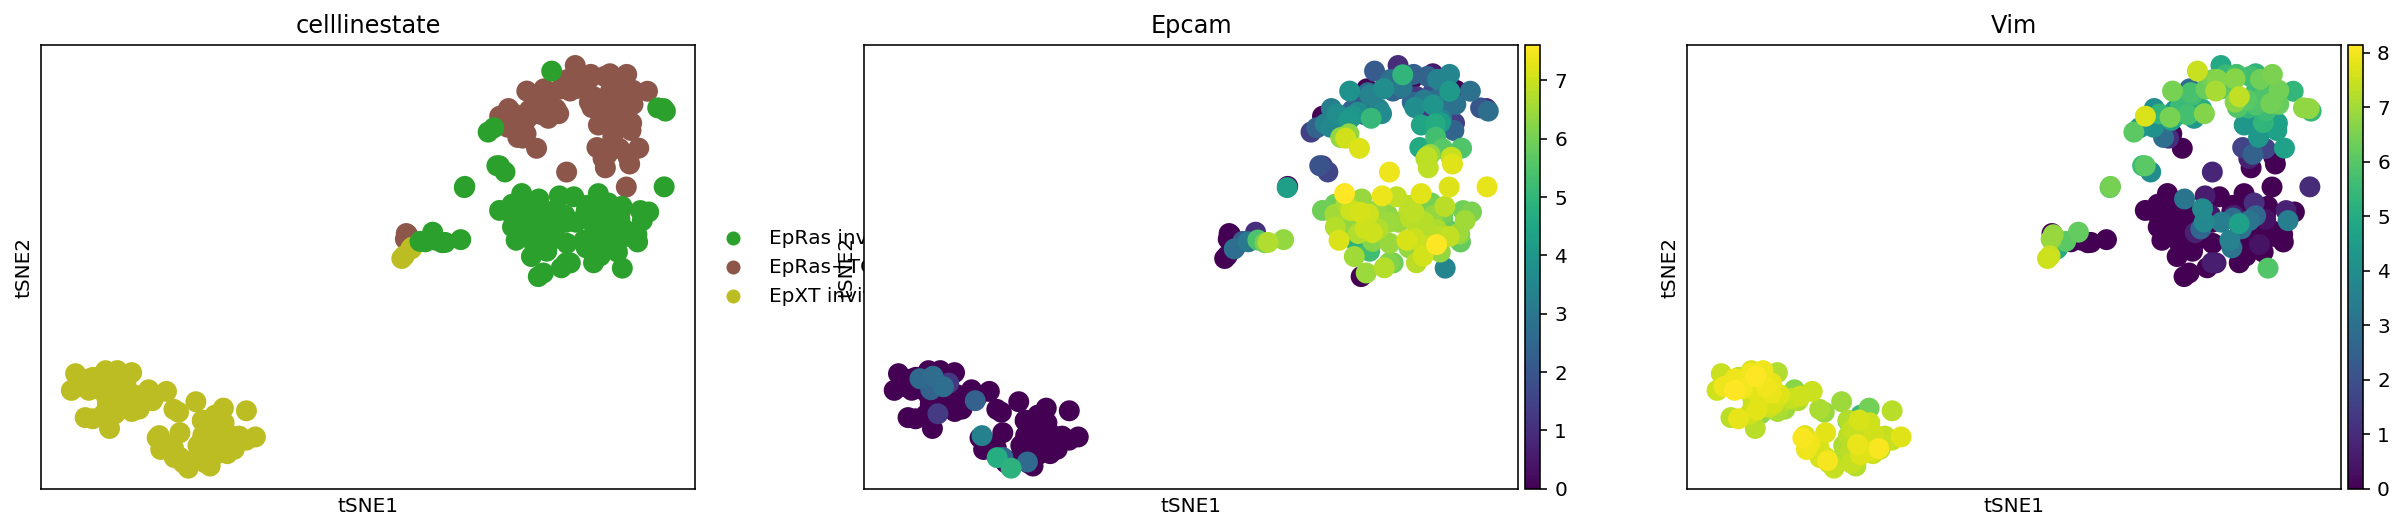

In [141]:
sc.tl.tsne(adata_invitro_biolvar)
sc.pl.tsne(adata_invitro_biolvar, color=['celllinestate','Epcam','Vim'], save='invitro-tsne.pdf')

computing UMAP
    finished (0:00:00.48) --> added
    'X_umap', UMAP coordinates (adata.obsm)
saving figure to file ./figures/umapinvitro-umap.pdf


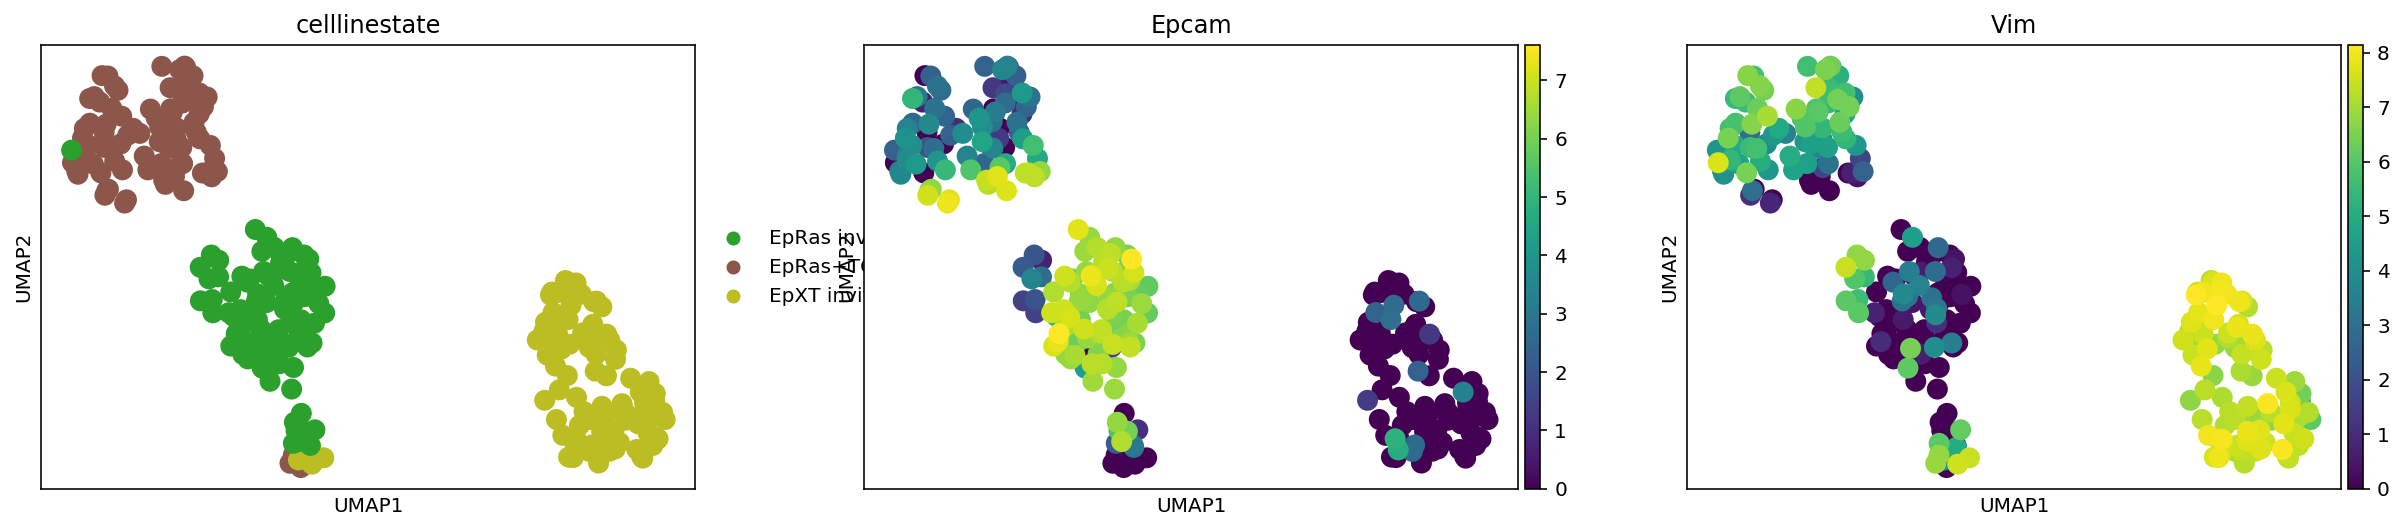

In [142]:
sc.tl.umap(adata_invitro_biolvar)
sc.pl.umap(adata_invitro_biolvar, color=['celllinestate','Epcam','Vim'], save='invitro-umap.pdf')

saving figure to file ./figures/violininvitro-markers.pdf


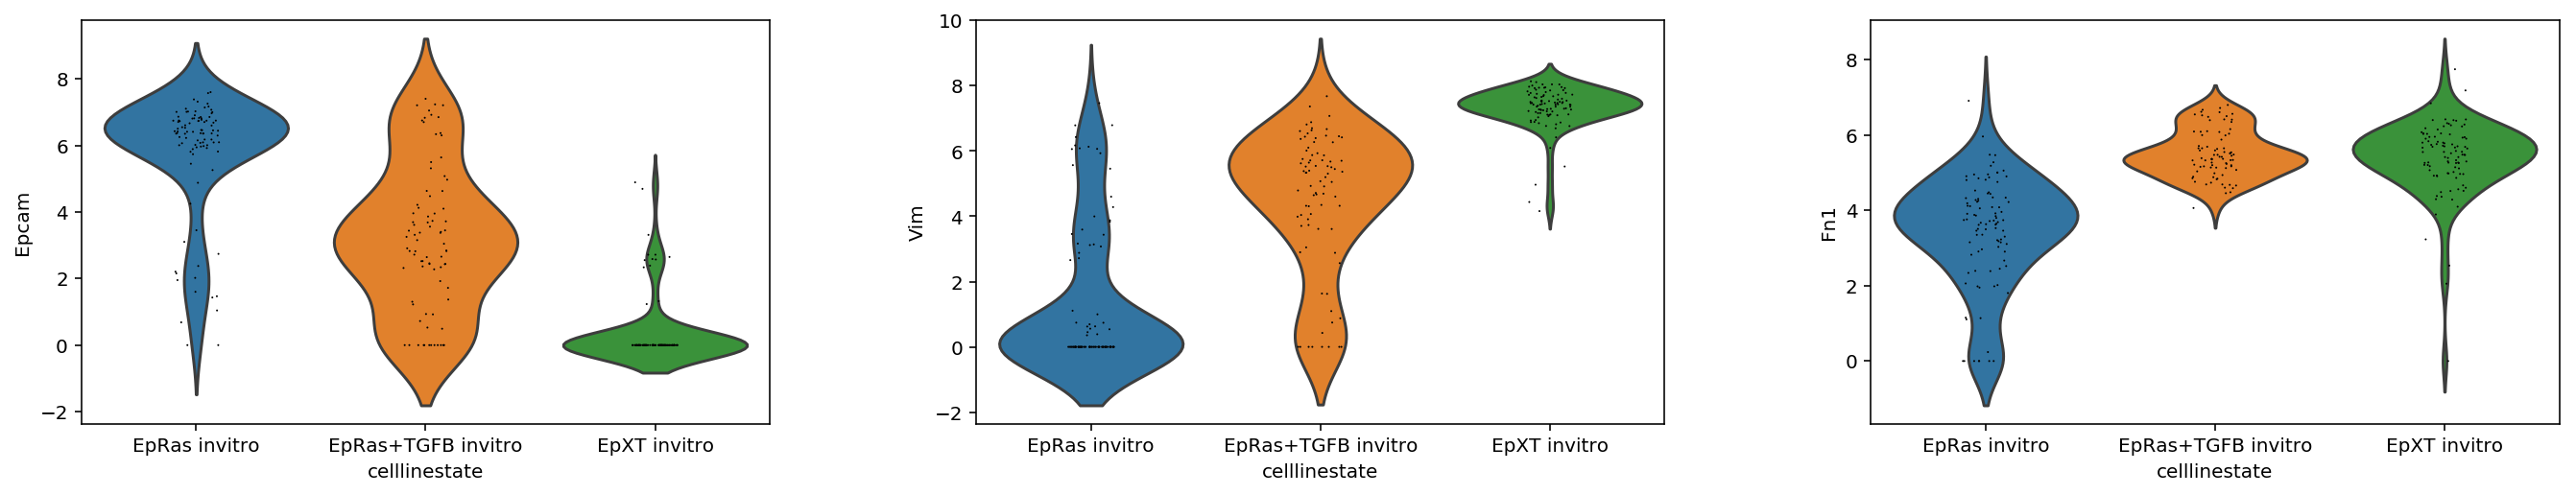

In [144]:
sc.pl.violin(adata_invitro, ['Epcam', 'Vim', 'Fn1'], groupby='celllinestate', save='invitro-markers.pdf')